Lambda School Data Science

*Unit 2, Sprint 2, Module 1*

---

In [ ]:
    !pip install category_encoders==2.*
    !pip install pandas_profiling==2.*

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

pd.options.display.max_rows = 100

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Module Project: Decision Trees

This week, the module projects will focus on creating and improving a model for the Tanazania Water Pump dataset. Your goal is to create a model to predict whether a water pump is functional, non-functional, or needs repair.

Dataset source: [DrivenData.org](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/).

## Directions

The tasks for this project are as follows:

- **Task 1:** Sign up for a [Kaggle](https://www.kaggle.com/) account.
- **Task 2:** Use `wrangle` function to import training and test data.
- **Task 3:** Split training data into feature matrix `X` and target vector `y`.
- **Task 4:** Split feature matrix `X` and target vector `y` into training and test sets.
- **Task 5:** Establish the baseline accuracy score for your dataset.
- **Task 6:** Build and train `model_dt`.
- **Task 7:** Calculate the training and validation accuracy score for your model.
- **Task 8:** Adjust model's `max_depth` to reduce overfitting.
- **Task 9 `stretch goal`:** Create a horizontal bar chart showing the 10 most important features for your model.

You should limit yourself to the following libraries for this project:

- `category_encoders`
- `matplotlib`
- `pandas`
- `pandas-profiling`
- `sklearn`

# Kaggle

**Task 1:** [Sign up for a Kaggle account](https://www.kaggle.com/), if you don’t already have one. **We recommend that you choose a username that's based on your name, since you might include it in your resume in the future.** Go to our Kaggle InClass competition website (the URL is in Slack). Go to the **Rules** page. Accept the rules of the competition. Notice that the **Rules** page also has instructions for the Submission process. The **Data** page has feature definitions.

# I. Wrangle Data

In [38]:
train = pd.merge(pd.read_csv('train_features.csv', na_values=[0, -2.00000e-08]), pd.read_csv('train_labels.csv', na_values=[0, -2.00000e-08]))

def wrangle(df):
    
    # Set id as index
    df.set_index('id', inplace=True)

    # Drop constant columns
    df.drop(columns= 'recorded_by', inplace=True)

    # # Drop duplicate columns
    # df.drop(columns= 'quantity group')

    #Drop HCCCs
    cutoff = 100
    drop_cols = [col for col in df.select_dtypes('object').columns
                 if df[col].nunique() > cutoff]
    df.drop(columns=drop_cols, inplace=True)

    # Strip differing words between the two datasets
    df.drop(columns= ['waterpoint_type_group', 'payment_type'], inplace=True)


    #Drop duplicate columns and account for the difference in X_test
    dupe_cols = [col for col in df.head(15).T.duplicated().index
                 if df.head(15).T.duplicated()[col]]
    df.drop(columns=dupe_cols, inplace=True)             

    # Drop num_private since there are 98% missing values in that column

    df.drop(columns='num_private', inplace=True)

    return df

df = wrangle(train)

df.head(15)

,amount_tsh,gps_height,longitude,latitude,basin,region,region_code,district_code,population,public_meeting,scheme_management,permit,construction_year,extraction_type,extraction_type_class,management,management_group,payment,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,status_group
id,,,,,,,,,,,,,,,,,,,,,,,,,,
454.0,50.0,2092.0,35.426020,-4.227446,Internal,Manyara,21,1.0,160.0,True,Water Board,True,1998.0,gravity,gravity,water board,user-group,pay per bucket,soft,good,insufficient,spring,spring,groundwater,communal standpipe,functional
510.0,NaN,NaN,35.510074,-5.724555,Internal,Dodoma,1,6.0,NaN,True,VWC,True,NaN,india mark ii,handpump,vwc,user-group,never pay,soft,good,enough,shallow well,shallow well,groundwater,hand pump,functional
14146.0,NaN,NaN,32.499866,-9.081222,Lake Rukwa,Mbeya,12,6.0,NaN,True,VWC,False,NaN,other,other,vwc,user-group,never pay,soft,good,enough,shallow well,shallow well,groundwater,other,non functional
47410.0,NaN,NaN,34.060484,-8.830208,Rufiji,Mbeya,12,7.0,NaN,True,VWC,True,NaN,gravity,gravity,vwc,user-group,pay monthly,soft,good,insufficient,river,river/lake,surface,communal standpipe,non functional
1288.0,300.0,1023.0,37.032690,-6.040787,Wami / Ruvu,Morogoro,5,1.0,120.0,True,VWC,True,1997.0,other,other,vwc,user-group,pay when scheme fails,salty,salty,enough,shallow well,shallow well,groundwater,other,non functional
13095.0,NaN,NaN,33.509112,-2.648505,Lake Victoria,Mwanza,19,2.0,NaN,True,VWC,True,NaN,nira/tanira,handpump,vwc,user-group,never pay,salty,salty,enough,shallow well,shallow well,groundwater,hand pump,functional
558.0,NaN,NaN,33.731347,-3.284633,Internal,Shinyanga,17,2.0,NaN,True,WUG,False,NaN,nira/tanira,handpump,wug,user-group,other,soft,good,seasonal,shallow well,shallow well,groundwater,hand pump,functional
35626.0,NaN,298.0,36.864072,-7.935517,Rufiji,Morogoro,5,3.0,250.0,True,NaN,True,2009.0,swn 80,handpump,vwc,user-group,never pay,soft,good,insufficient,shallow well,shallow well,groundwater,hand pump,functional
8696.0,NaN,NaN,33.423658,-2.606991,Lake Victoria,Mwanza,19,2.0,NaN,True,VWC,True,NaN,mono,motorpump,vwc,user-group,never pay,soft,good,enough,machine dbh,borehole,groundwater,communal standpipe,non functional


In [29]:
# dupe_cols = [col for col in df.head(15).T.duplicated().index
#                   if df.head(15).T.duplicated()[col]]

# print(dupe_cols)

['extraction_type_group', 'quantity_group', 'waterpoint_type_group']


In [ ]:
# Report = ProfileReport(train, minimal=True).to_notebook_iframe()
# Report

In [ ]:
#X_test = pd.read_csv('test_features.csv')
#Report_test = ProfileReport(X_test, minimal= True).to_notebook_iframe()

**Task 1:** Using the `wrangle` function above, read the `train_features.csv` and  `train_labels.csv` files into the DataFrame `df`. Next, use the same function to read the test set `test_features.csv` into the DataFrame `X_test`.

In [40]:
# df is called above
# now call in your test DataFrame as X_test

test = pd.read_csv('test_features.csv', na_values=[0, -2.00000e-08])

X_test = wrangle(test)

In [41]:
X_test.shape

(11880, 25)

In [42]:
df.shape

(47520, 26)

In [43]:
X_test.head(15)

,amount_tsh,gps_height,longitude,latitude,basin,region,region_code,district_code,population,public_meeting,scheme_management,permit,construction_year,extraction_type,extraction_type_class,management,management_group,payment,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type
id,,,,,,,,,,,,,,,,,,,,,,,,,
37098,NaN,NaN,31.985658,-3.596360,Lake Tanganyika,Shinyanga,17,5.0,NaN,True,WUG,True,NaN,other,other,wug,user-group,unknown,soft,good,dry,shallow well,shallow well,groundwater,other
14530,NaN,NaN,32.832815,-4.944937,Lake Tanganyika,Tabora,14,6.0,NaN,True,VWC,True,NaN,india mark ii,handpump,vwc,user-group,never pay,milky,milky,insufficient,shallow well,shallow well,groundwater,hand pump
62607,10.0,1675.0,35.488289,-4.242048,Internal,Manyara,21,1.0,148.0,True,Water Board,True,2008.0,gravity,gravity,water board,user-group,pay per bucket,soft,good,insufficient,spring,spring,groundwater,communal standpipe
46053,NaN,NaN,33.140828,-9.059386,Lake Rukwa,Mbeya,12,6.0,NaN,False,VWC,False,NaN,nira/tanira,handpump,vwc,user-group,never pay,soft,good,seasonal,shallow well,shallow well,groundwater,hand pump
47083,50.0,1109.0,34.217077,-4.430529,Internal,Singida,13,1.0,235.0,True,WUA,True,2011.0,mono,motorpump,wua,user-group,pay per bucket,soft,good,enough,machine dbh,borehole,groundwater,communal standpipe multiple
12465,NaN,149.0,38.987944,-8.314887,Rufiji,Pwani,60,53.0,1.0,True,VWC,True,2009.0,other,other,vwc,user-group,never pay,soft,good,enough,machine dbh,borehole,groundwater,communal standpipe multiple
12921,NaN,NaN,31.418240,-1.606798,Lake Victoria,Kagera,18,2.0,NaN,True,VWC,True,NaN,gravity,gravity,vwc,user-group,never pay,soft,good,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe
14606,6000.0,1333.0,35.465845,-7.711371,Rufiji,Iringa,11,1.0,1.0,True,VWC,True,1994.0,gravity,gravity,vwc,user-group,pay annually,soft,good,dry,spring,spring,groundwater,communal standpipe
9417,NaN,NaN,30.983023,-1.680654,Lake Victoria,Kagera,18,1.0,NaN,True,NaN,True,NaN,gravity,gravity,private operator,commercial,never pay,soft,good,dry,rainwater harvesting,rainwater harvesting,surface,communal standpipe


In [44]:
print(df.columns) 
X_test.columns

Index(['amount_tsh', 'gps_height', 'longitude', 'latitude', 'basin', 'region',
       'region_code', 'district_code', 'population', 'public_meeting',
       'scheme_management', 'permit', 'construction_year', 'extraction_type',
       'extraction_type_class', 'management', 'management_group', 'payment',
       'water_quality', 'quality_group', 'quantity', 'source', 'source_type',
       'source_class', 'waterpoint_type', 'status_group'],
      dtype='object')


Index(['amount_tsh', 'gps_height', 'longitude', 'latitude', 'basin', 'region',
       'region_code', 'district_code', 'population', 'public_meeting',
       'scheme_management', 'permit', 'construction_year', 'extraction_type',
       'extraction_type_class', 'management', 'management_group', 'payment',
       'water_quality', 'quality_group', 'quantity', 'source', 'source_type',
       'source_class', 'waterpoint_type'],
      dtype='object')

# II. Split Data

**Task 3:** Split your DataFrame `df` into a feature matrix `X` and the target vector `y`. You want to predict `'status_group'`.

In [68]:
# Split
target = 'status_group'

y = train[target]
X = train.drop(columns = target)

In [69]:
print(X_test.shape)
print(X.shape)
print(y.shape)

(11880, 25)
(47520, 25)
(47520,)


**Task 4:** Using a randomized split, divide `X` and `y` into a training set (`X_train`, `y_train`) and a validation set (`X_val`, `y_val`).

In [70]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size= .2, random_state= 42)

# III. Establish Baseline

**Task 5:** Since this is a **classification** problem, you should establish a baseline accuracy score. Figure out what is the majority class in `y_train` and what percentage of your training observations it represents.

In [71]:
# Baseline prediction of 'functional' 

baseline_acc = y_train.value_counts(normalize = True).max()
print('Baseline Accuracy Score:', baseline_acc)

Baseline Accuracy Score: 0.5440867003367004


# IV. Build Model

**Task 6:** Build a `Pipeline` named `model_dt`, and fit it to your training data. Your `Pipeline` should include:

- an `OrdinalEncoder` transformer for categorical features.
- a `SimpleImputer` transformer fot missing values.
- a `DecisionTreeClassifier` predictor.

**Note:** Don't forget to set the `random_state` parameter for your `DecisionTreeClassifier`.

In [98]:
model_dt = make_pipeline(
      OrdinalEncoder(),
      SimpleImputer(strategy= 'mean'),
      DecisionTreeClassifier(max_depth= 16, random_state= 42)

                         )

model_dt.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['basin', 'region', 'public_meeting',
                                      'scheme_management', 'permit',
                                      'extraction_type',
                                      'extraction_type_class', 'management',
                                      'management_group', 'payment',
                                      'water_quality', 'quality_group',
                                      'quantity', 'source', 'source_type',
                                      'source_class', 'waterpoint_type'],
                                drop_invariant=False, handle_missing=...
                               missing_values=nan, strategy='mean',
                               verbose=0)),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                        criterion='gini', max_depth=16,
 

# V. Check Metrics

**Task 7:** Calculate the training and validation accuracy scores for `model_dt`.

In [99]:
# Check the metrics of your model

training_acc = accuracy_score(y_train, model_dt.predict(X_train))
val_acc = accuracy_score(y_val, model_dt.predict(X_val))

print('Training Accuracy Score:', training_acc)
print('Validation Accuracy Score:', val_acc)

Training Accuracy Score: 0.8779724326599326
Validation Accuracy Score: 0.7635732323232324


# VI. Tune Model

**Task 8:** Is there a large difference between your training and validation accuracy? If so, experiment with different setting for `max_depth` in your `DecisionTreeClassifier` to reduce the amount of overfitting in your model.

In [92]:
# Use this cell to experiment and then change 
# your model hyperparameters in Task 6

depths = range(12, 20, 1)

list(depths)

[12, 13, 14, 15, 16, 17, 18, 19]

In [93]:
train_acc = []
val_acc = []

for depth in depths: 

  tree_model = make_pipeline(
      OrdinalEncoder(),
      SimpleImputer(),
      DecisionTreeClassifier(max_depth= depth, random_state= 42)
  )

  tree_model.fit(X_train, y_train)
  train_acc.append(tree_model.score(X_train, y_train))
  val_acc.append(tree_model.score(X_val, y_val))

In [94]:
train_acc

[0.8056607744107744,
 0.8219960016835017,
 0.8412773569023569,
 0.8601378367003367,
 0.8779724326599326,
 0.8934659090909091,
 0.9073021885521886,
 0.921690867003367]

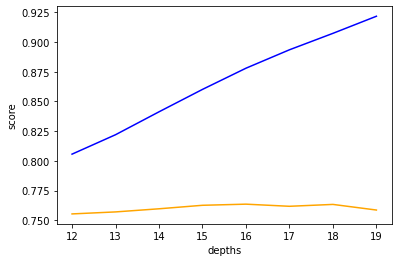

In [95]:
plt.plot(depths, train_acc, color= 'blue', label= 'training')
plt.plot(depths, val_acc, color= 'orange', label= 'validation')
plt.xlabel('depths')
plt.ylabel('score')
plt.show()

# VII. Communicate Results

**Task 9 `stretch goal`:** Create a horizontal barchart that shows the the 10 most important features for model_dt, sorted by value.

**Note:** [`DecisionTreeClassifier.feature_importances_`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html?highlight=decisiontreecla#sklearn.tree.DecisionTreeClassifier.feature_importances_) returns values that are different from [`LogisticRegression.coef_`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). All the values will be positive, and they will sum to `1`.

Text(0, 0.5, 'features')

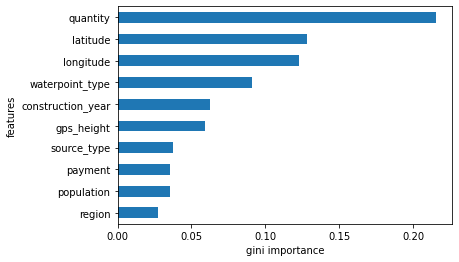

In [101]:
features = model_dt.named_steps['ordinalencoder'].get_feature_names()
gini = model_dt.named_steps['decisiontreeclassifier'].feature_importances_

pd.Series(data= gini, index= features).sort_values(key=abs).tail(10).plot(kind= 'barh')
plt.xlabel('gini importance')
plt.ylabel('features')

In [102]:
# Check to make sure X_test and X_train have the same shape

print(X_test.shape)
print(X.shape)
print(y.shape)

(11880, 25)
(47520, 25)
(47520,)


In [103]:
# Run your model on X_test

model_dt.predict(X_test)

array(['non functional', 'functional', 'functional', ...,
       'non functional', 'functional', 'functional'], dtype=object)

In [104]:
# Create your DataFrame

predictions = pd.DataFrame(data=model_dt.predict(X_test), index=X_test.index)

predictions.columns = ['status_group']

predictions.head()

,status_group
id,
37098,non functional
14530,functional
62607,functional
46053,non functional
47083,functional


In [105]:
# Generate CSV 

predictions.to_csv('ds29_Luke_Sislowski_sprint1.csv')

In [106]:
# Download CSV

from google.colab import files
files.download('ds29_Luke_Sislowski_sprint1.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>